# Paragraph Segmentation
This notebook investigates methods to identify segment handwritten passages from images that contains printed and handwritten text using **DCNN**

*Input*: a png from the IAM dataset with the "form" input and output type of "bb" and form.

*Output*: a bounding boxes of the paragraphs.


In [3]:
import multiprocessing
import time
import random
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import mxnet as mx
import numpy as np
from skimage.draw import line_aa
from skimage import transform as skimage_transform

from mxnet import nd, autograd, gluon
from mxnet.image import resize_short
from mxboard import SummaryWriter


from ocr.utils.iam_dataset import IAMDataset
from ocr.utils.iou_loss import IOU_loss
from ocr.utils.draw_box_on_image import draw_box_on_image

model_checkpoint_folder = "model_checkpoint"
if not os.path.isdir(model_checkpoint_folder):
    os.makedirs(model_checkpoint_folder)
    
ctx = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()
mx.random.seed(42)


## Dataset creation

In [4]:
train_ds = IAMDataset("form", output_data="bb", output_parse_method="form", train=True)
print("Number of training samples: {}".format(len(train_ds)))

test_ds = IAMDataset("form", output_data="bb", output_parse_method="form", train=False)
print("Number of testing samples: {}".format(len(test_ds)))

Number of training samples: 967
Number of testing samples: 232


Two transforms were used, the "transform" function only resizes and normalises the image. The "augment_transform" function randomly shifts the image and predicted bounding box by 5% then called the "transform" function.

In [5]:
batch_size = 32

random_y_translation, random_x_translation = (0.2, 0.2) # Randomly translate the input image
expand_bb_scale = 0.03 # Expand the bounding box to relax the boundaries 

In [6]:
def transform(data, label):
    '''
    Function that converts "data"" into the input image tensor for a CNN
    Label is converted into a float tensor.
    '''
    image = mx.nd.array(data).expand_dims(axis=2)
    image = resize_short(image, int(800/3))
    image = image.transpose([2, 0, 1])/255.
    label = label[0].astype(np.float32)
    
    bb = label.copy()
    new_w = (1 + expand_bb_scale) * bb[2]
    new_h = (1 + expand_bb_scale) * bb[3]
    
    bb[0] = bb[0] - (new_w - bb[2])/2
    bb[1] = bb[1] - (new_h - bb[3])/2
    bb[2] = new_w
    bb[3] = new_h

    return image, mx.nd.array(bb)

def augment_transform(data, label):
    '''
    Function that randomly translates the input image by +-width_range and +-height_range.
    The labels (bounding boxes) are also translated by the same amount.
    '''
    ty = random.uniform(-random_y_translation, random_y_translation)
    tx = random.uniform(-random_x_translation, random_x_translation)
    st = skimage_transform.SimilarityTransform(translation=(tx*data.shape[1], ty*data.shape[0]))
    data = skimage_transform.warp(data, st)
    label = label.copy()
    label[0][0] = label[0][0] - tx
    label[0][1] = label[0][1] - ty
    return transform(data*255., label)

In [7]:
train_data = gluon.data.DataLoader(train_ds.transform(augment_transform), batch_size, shuffle=True, num_workers=8)
test_data = gluon.data.DataLoader(test_ds.transform(transform), batch_size, shuffle=False, num_workers=8)

## Network creation

In [8]:
class SegmentationNetwork(gluon.nn.HybridBlock):
    
    def __init__(self, p_dropout = 0.5, ctx=mx.cpu()):
        super(SegmentationNetwork, self).__init__()

        pretrained = gluon.model_zoo.vision.resnet34_v1(pretrained=True, ctx=ctx)
        first_weights = pretrained.features[0].weight.data().mean(axis=1).expand_dims(axis=1)

        body = gluon.nn.HybridSequential(prefix="SegmentationNetwork_")
        with body.name_scope():
            first_layer = gluon.nn.Conv2D(channels=64, kernel_size=(7, 7), padding=(3, 3), strides=(2, 2), in_channels=1, use_bias=False)
            first_layer.initialize(mx.init.Normal(), ctx=ctx)
            first_layer.weight.set_data(first_weights)
            body.add(first_layer)
            body.add(*pretrained.features[1:6])
        
            output = gluon.nn.HybridSequential()
            with output.name_scope():
                output.add(gluon.nn.Flatten())
                output.add(gluon.nn.Dense(64, activation='relu'))
                output.add(gluon.nn.Dropout(p_dropout))
                output.add(gluon.nn.Dense(64, activation='relu'))
                output.add(gluon.nn.Dropout(p_dropout))
                output.add(gluon.nn.Dense(4, activation='sigmoid'))

            output.collect_params().initialize(mx.init.Normal(), ctx=ctx)
            body.add(output)
        self.cnn = body

    def hybrid_forward(self, F, x):
        return self.cnn(x)

net = SegmentationNetwork()
net.hybridize()
net.collect_params().reset_ctx(ctx)

## Define epoch

In [9]:
print_every_n = 1
send_image_every_n = 20

def run_epoch(e, network, dataloader, loss_function, trainer, log_dir, print_name, is_train):
    total_loss = nd.zeros(1, ctx)
    for i, (data, label) in enumerate(dataloader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        with autograd.record(train_mode=is_train):
            output = network(data)
            loss_i = loss_function(output, label)
        if is_train:
            loss_i.backward()
            trainer.step(data.shape[0])

        total_loss += loss_i.mean()
        
        if e % send_image_every_n == 0 and e > 0 and i == 0:
            output_image = draw_box_on_image(output.asnumpy(), label.asnumpy(), data.asnumpy())
    epoch_loss = float(total_loss .asscalar())/len(dataloader)
    
    with SummaryWriter(logdir=log_dir, verbose=False, flush_secs=5) as sw:
        sw.add_scalar('loss', {print_name: epoch_loss}, global_step=e)
        if e % send_image_every_n == 0 and e > 0:
            output_image[output_image<0] = 0
            output_image[output_image>1] = 1
            sw.add_image('bb_{}_image'.format(print_name), output_image, global_step=e)
            
    return epoch_loss

## Pre training
The network was initially trained on 300 epochs using the Mean squared error (L2 loss) as a loss function. This was performed because without reasonable bounding boxes (ie. overlapping bounding boxes), the IOU loss will not function properly. 

In [10]:
checkpoint_name = "cnn_mse.params"
best_test_loss = 10e5

In [11]:
loss_function = gluon.loss.L2Loss()
epochs = 11
learning_rate = 0.00005
log_dir = "./logs/paragraph_segmentation"

In [12]:
if os.path.isfile(os.path.join(model_checkpoint_folder, checkpoint_name)):
    net.load_parameters(os.path.join(model_checkpoint_folder, checkpoint_name))


In [13]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate})

In [14]:
#net.cnn.load_parameters('models/paragraph_segmentation2.params')
#run_epoch(0, net, test_data, loss_function=loss_function, log_dir=log_dir, trainer=trainer, print_name="test", is_train=False)
#0.00018943558097817004   

In [15]:
for e in range(epochs):
    train_loss = run_epoch(e, net, train_data, loss_function=loss_function, log_dir=log_dir, 
                           trainer=trainer, print_name="train", is_train=True)
    test_loss = run_epoch(e, net, test_data, loss_function=loss_function, log_dir=log_dir,
                          trainer=trainer, print_name="test", is_train=False)
    if test_loss < best_test_loss:
        print("Saving network, previous best test loss {:.6f}, current test loss {:.6f}".format(best_test_loss, test_loss))
        net.save_parameters(os.path.join(model_checkpoint_folder, checkpoint_name))
        best_test_loss = test_loss
    if e % print_every_n == 0 and e > 0:
        print("Epoch {0}, train_loss {1:.6f}, test_loss {2:.6f}".format(e, train_loss, test_loss))

Saving network, previous best test loss 1000000.000000, current test loss 0.005283
Saving network, previous best test loss 0.005283, current test loss 0.001491
Epoch 1, train_loss 0.009336, test_loss 0.001491
Saving network, previous best test loss 0.001491, current test loss 0.001358
Epoch 2, train_loss 0.007296, test_loss 0.001358
Saving network, previous best test loss 0.001358, current test loss 0.001344
Epoch 3, train_loss 0.006420, test_loss 0.001344
Saving network, previous best test loss 0.001344, current test loss 0.001330
Epoch 4, train_loss 0.005734, test_loss 0.001330
Epoch 5, train_loss 0.005233, test_loss 0.001436
Saving network, previous best test loss 0.001330, current test loss 0.001324
Epoch 6, train_loss 0.005051, test_loss 0.001324
Epoch 7, train_loss 0.004633, test_loss 0.001495
Saving network, previous best test loss 0.001324, current test loss 0.001324
Epoch 8, train_loss 0.004554, test_loss 0.001324
Epoch 9, train_loss 0.004283, test_loss 0.001347
Saving network

### Fine tuning
After training the network with the mean squared error loss, the IOU loss was used to fine tune the network. The IOU loss is more finegrained as it maximises the overlap between the bounding boxes.

In [19]:
if os.path.isfile(os.path.join(model_checkpoint_folder, checkpoint_name)):
    net.load_parameters(os.path.join(model_checkpoint_folder, checkpoint_name))

fine_tuning = True # I found this to consistently decrease the qualitative results

In [20]:
if fine_tuning:
    checkpoint_name = "cnn_iou.params"
    loss_function = IOU_loss()
    epochs = 150
    learning_rate = 0.00005
    log_dir = "./logs"

    best_test_loss = 10e5

    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, })

    for e in range(epochs):
        train_loss = run_epoch(e, net, train_data, loss_function=loss_function, log_dir=log_dir, 
                               trainer=trainer, print_name="train", is_train=True)
        test_loss = run_epoch(e, net, test_data, loss_function=loss_function, log_dir=log_dir,
                              trainer=trainer, print_name="test", is_train=False)
        if test_loss < best_test_loss:
            print("Saving network, previous best test loss {:.6f}, current test loss {:.6f}".format(best_test_loss, test_loss))
            net.save_parameters("{}/{}".format(model_checkpoint_folder, checkpoint_name))
            best_test_loss = test_loss
        if e % print_every_n == 0 and e > 0:
            print("Epoch {0}, train_loss {1:.6f}, test_loss {2:.6f}".format(e, train_loss, test_loss))

Saving network, previous best test loss 1000000.000000, current test loss 0.310079
Saving network, previous best test loss 0.310079, current test loss 0.308380
Epoch 1, train_loss 0.514384, test_loss 0.308380
Saving network, previous best test loss 0.308380, current test loss 0.304052
Epoch 2, train_loss 0.499607, test_loss 0.304052
Saving network, previous best test loss 0.304052, current test loss 0.295819
Epoch 3, train_loss 0.478438, test_loss 0.295819
Epoch 4, train_loss 0.486888, test_loss 0.311232
Epoch 5, train_loss 0.461800, test_loss 0.296499
Epoch 6, train_loss 0.463498, test_loss 0.347314
Epoch 7, train_loss 0.449789, test_loss 0.306561
Epoch 8, train_loss 0.465756, test_loss 0.318774
Epoch 9, train_loss 0.454839, test_loss 0.310107
Epoch 10, train_loss 0.443893, test_loss 0.308099
Epoch 11, train_loss 0.449219, test_loss 0.320697


KeyboardInterrupt: 

## Results
The training and test MSE is printed out in this notebook. The loss and the images with predicted bounding boxes is shown on below. Both this information can be viewed on [mxboard](https://medium.com/apache-mxnet/mxboard-mxnet-data-visualization-2eed6ae31d2c) while the network is training. 

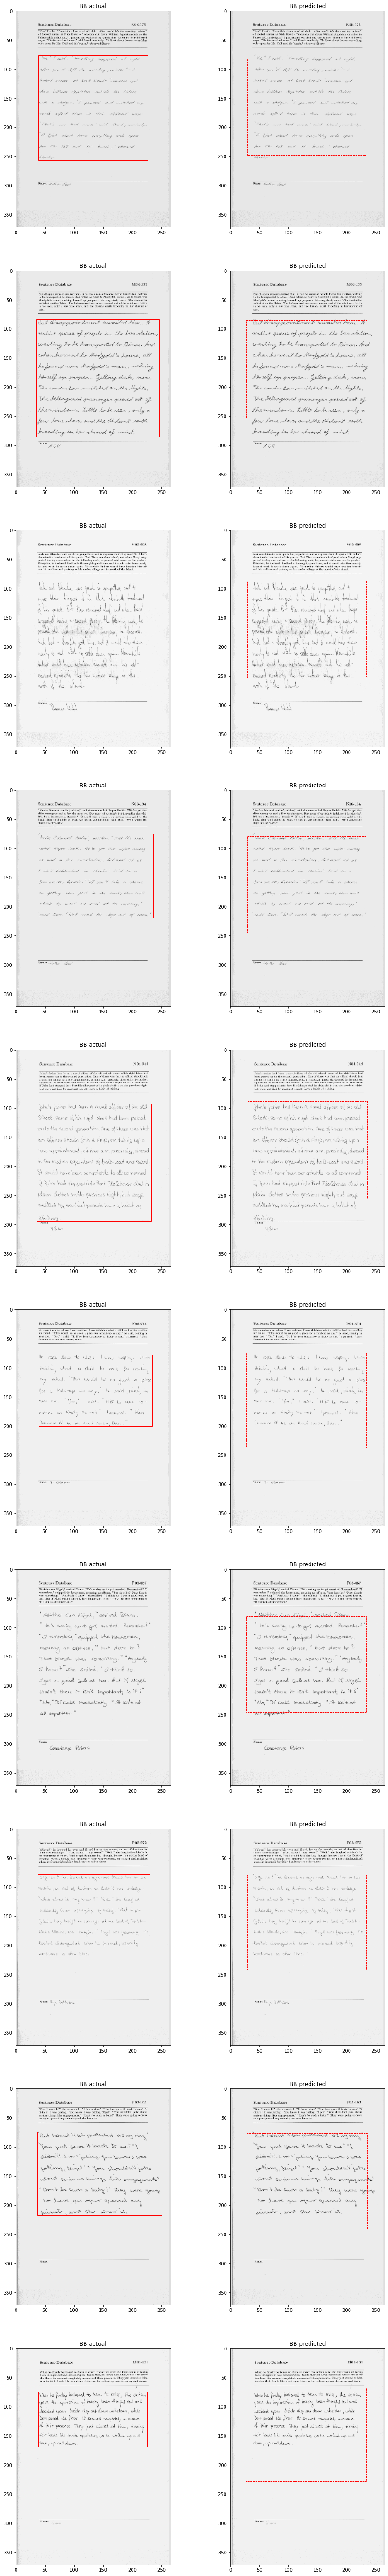

In [18]:
figs_to_plot = 10
fig, axs = plt.subplots(figs_to_plot, 2, figsize=(15, 10 * figs_to_plot))

for i in range(figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, bb = test_ds[n]

    image, _ = transform(image, bb)
    image = image.as_in_context(ctx)
    image = image.expand_dims(axis=0)
    bb_predicted = net(image)

    (x, y, w, h) = bb[0]
    axs[i][0].imshow(image.asnumpy().squeeze(), cmap='Greys_r')
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[i][0].add_patch(rect)
    axs[i][0].set_title("BB actual")

    axs[i][1].imshow(image.asnumpy().squeeze(), cmap='Greys_r')
    (x, y, w, h) = bb_predicted[0].asnumpy()
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[i][1].add_patch(rect)
    axs[i][1].set_title("BB predicted")